# Import

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Utils

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
def noisy_distance(loc):
    noise = np.random.normal(0, 0.3, 3)
    r1 = np.linalg.norm(loc - CFG.anchor[0]) + noise[0]
    r2 = np.linalg.norm(loc - CFG.anchor[1]) + noise[1]
    r3 = np.linalg.norm(loc - CFG.anchor[2]) + noise[2]
    return r1, r2, r3

In [5]:
def trilateration(r1, r2, r3):
    # Extract anchor coordinates from CFG
    x1, y1 = CFG.anchor[0]
    x2, y2 = CFG.anchor[1]
    x3, y3 = CFG.anchor[2]

    # Calculate components A, B, C, D, E, F
    A = 2 * (x2 - x1)
    B = 2 * (y2 - y1)
    C = r1**2 - r2**2 - x1**2 + x2**2 - y1**2 + y2**2

    D = 2 * (x3 - x2)
    E = 2 * (y3 - y2)
    F = r2**2 - r3**2 - x2**2 + x3**2 - y2**2 + y3**2

    # Construct matrices for solving linear equations
    M = np.linalg.inv(np.array([[A, B], [D, E]]))
    N = np.array([C, F])
    
    return M @ N

In [6]:
def rms_error(true_values, estimated_values):
    return np.sqrt(np.mean((np.array(true_values) - np.array(estimated_values))**2))

# Setup

In [13]:
class CFG:
    seed = 42
    # initialize anchor positions
    anchor = np.array([[0, 0], [10, 10], [0, 10]])
    # initial state
    x_k = np.array([3, 0, 1, 0]).T
    # state transition matrix
    F = np.array([
        [1, 0, .5, 0],
        [0, 1, 0, .5],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]).T
    # observation matrix
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ]).T
    # initial state covariance matrix
    P_k = np.eye(4, 4) * np.var(np.array([3, 0, 1, 0])) 
    # process noise covariance
    Q = np.eye(4, 4)
    num_step = 100

# Algorithm

In [16]:
def kalman_filter_simulation(CFG, R=np.eye(2)): # set simple Observation noise Covariance
    true_x, true_y = [], []
    noisy_x, noisy_y = [], []
    filtered_x, filtered_y = [], []

    x_k = CFG.x_k
    true_x_k = CFG.x_k
    P_k = CFG.P_k
    F = CFG.F
    H = CFG.H
    Q = CFG.Q

    set_seed(CFG.seed)
    # start
    for _ in range(CFG.num_step):
        # True position
        true_x.append(true_x_k[0])
        true_y.append(true_x_k[1])

        # Noisy measurement
        noisy = trilateration(*noisy_distance(true_x_k[:2]))
        noisy_x.append(noisy[0])
        noisy_y.append(noisy[1])

        # Kalman filter prediction and update
        y_k = noisy
        K_k = F @ P_k @ H @ np.linalg.inv(H.T @ P_k @ H + R)
        x_k_pred = F @ x_k + K_k @ (y_k - H.T @ x_k)
        P_k_correction = P_k - P_k @ H @ np.linalg.inv(H.T @ P_k @ H + R) @ H.T @ P_k
        P_k_pred = F @ P_k_correction @ F.T + Q

        # Store filtered estimates
        filtered_x.append(x_k_pred[0])
        filtered_y.append(x_k_pred[1])

        # Update state and covariance for next step
        x_k = x_k_pred
        P_k = P_k_pred
        true_x_k = true_x_k @ F + np.random.multivariate_normal(np.zeros(true_x_k.shape[0]), np.eye(true_x_k.shape[0]))

    return true_x, true_y, noisy_x, noisy_y, filtered_x, filtered_y

In [17]:
true_x, true_y, noisy_x, noisy_y, filtered_x, filtered_y = kalman_filter_simulation(CFG)

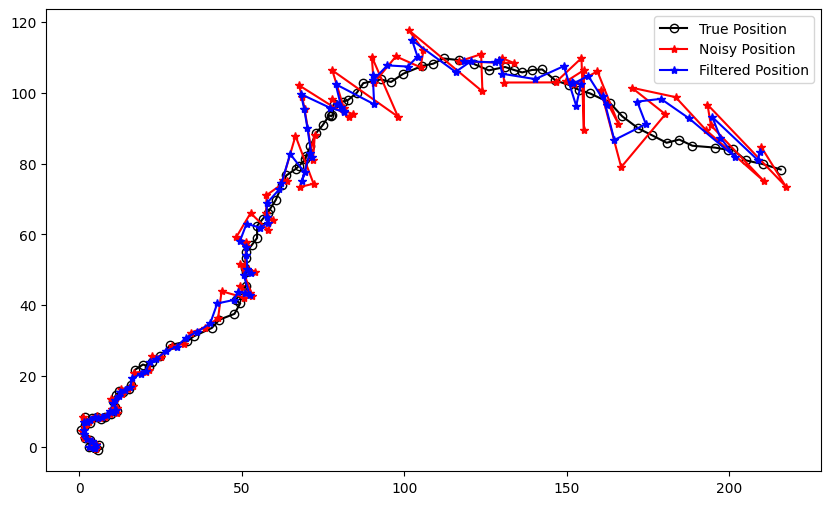

In [20]:
plt.figure(figsize=(10, 6))
# Plot True Positions
plt.plot(true_x, true_y, color='k', marker='o', linestyle='-', label="True Position", markerfacecolor='none')

# Plot Noisy positions
plt.plot(noisy_x, noisy_y, color='r', marker='*', linestyle='-', label="Noisy Position")

# Plot Filtered positions
plt.plot(filtered_x, filtered_y, color='b', marker='*', linestyle='-', label="Filtered Position")
plt.legend()
plt.show()

# Find best Observation noise covariance

In [29]:
def find_optimal_R(CFG):
    rms_errors = []
    R_values = np.logspace(-1, 1, 100)  # 1e-1 to 1e1, logarithmically spaced
    best_result = None

    for value in R_values:
        R = np.eye(2) * value
        true_x, true_y, _, _, filtered_x, filtered_y = kalman_filter_simulation(CFG, R)

        # Calculate RMS error between true and filtered values
        rms_error_x = rms_error(true_x, filtered_x)
        rms_error_y = rms_error(true_y, filtered_y)
        average_rms_error = (rms_error_x + rms_error_y) / 2
        rms_errors.append(average_rms_error)

        if best_result is None or average_rms_error < best_result[0]:
            best_result = (average_rms_error, value, true_x, true_y, filtered_x, filtered_y)

    # Plot RMS error vs R value
    plt.figure()
    plt.plot(R_values, rms_errors, marker='o')
    plt.xscale('log')
    plt.xlabel('R value (log scale)')
    plt.ylabel('Average RMS Error')
    plt.title('RMS Error vs R Value for Kalman Filter')
    plt.grid(True)
    plt.show()

    # Extract the optimal results
    optimal_R_value = best_result[1]
    true_x, true_y, filtered_x, filtered_y = best_result[2], best_result[3], best_result[4], best_result[5]
    print(f"Optimal R value: {optimal_R_value}")

    return optimal_R_value, (true_x, true_y, filtered_x, filtered_y)

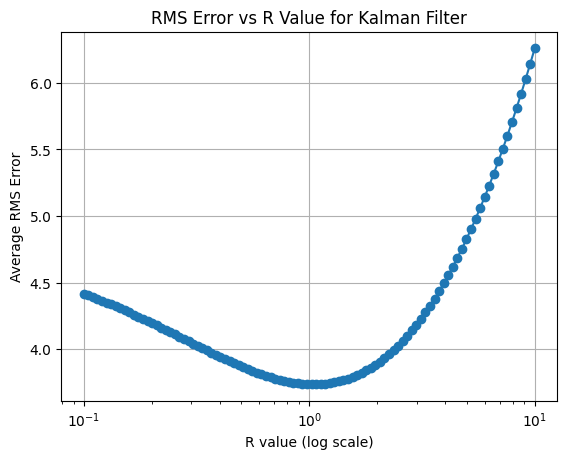

Optimal R value: 1.0235310218990263


In [25]:
optimal_R_value, (true_x, true_y, filtered_x, filtered_y) = find_optimal_R(CFG)

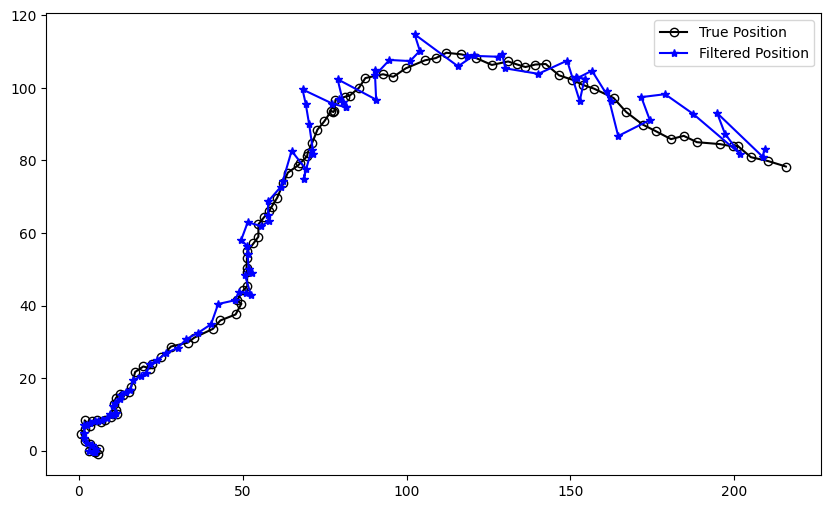

In [26]:
plt.figure(figsize=(10, 6))
# Plot True Positions
plt.plot(true_x, true_y, color='k', marker='o', linestyle='-', label="True Position", markerfacecolor='none')

# Plot Filtered positions
plt.plot(filtered_x, filtered_y, color='b', marker='*', linestyle='-', label="Filtered Position")
plt.legend()
plt.show()